# Brain Tumor Detection with CNN

#### 組員：羅際東、黃品慈、Calvin Tsai、何豐吉、Jean、Hao
### Table of Contents


1. 專案簡介及目標
   1. 資料集說明
   2. 何謂腦腫瘤
2. 建立環境
3. 資料載入及資料增強
4. CNN 模型
    1. vgg16模型
    2. 一般自定義模型
    3. 效能評估
5. 總結
6. 資料來源

# 1.專案簡介及目標
這個專案的主要目的是建立一個卷積神經網絡(CNN)模型,根據MRI掃描判斷受測者是否患有腫瘤。本專案使用了CNN和DNN對這個二元問題進行建模與訓練。最後將以**準確度**作為評估模型效能的指標

## 1.1 資料集說明
本專案的影像使用的是Kaggle資料集[Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?select=yes)。總共分兩類:


*   `NO` - 沒有腦腫瘤
*   `Yes` - 有腦腫瘤

註: 該資料集作者並未說明腦腫瘤影像的出處

## 1.2 何謂腦腫瘤
當大腦內形成異常細胞時，就會發生腦腫瘤。腫瘤主要有兩種：惡性腫瘤和良性（非癌性）腫瘤。這些腫瘤可以進一步分為原發性腫瘤（起始於腦內）和繼發性腫瘤（最常見的是從位於腦外的腫瘤擴散，稱為腦轉移瘤）。所有類型的腦腫瘤都可能產生不同的症狀，這取決於腫瘤的大小和所涉及的大腦部分。如果有症狀，可能包括頭痛、癲癇發作、視力問題、嘔吐和精神變化。其他症狀可能包括行走困難、說話困難、有感覺或失去知覺。

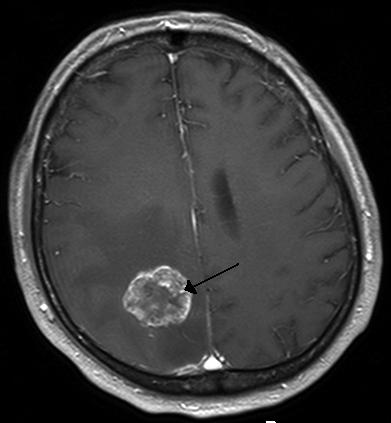

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# 2.建立環境


In [11]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [1]:
import cv2
import os
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.applications.vgg16 import VGG16

In [2]:
# 使用 google colab 時 mount 資料夾
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# 使用 google colab 時查看目錄結構
!apt-get install tree
clear_output()
# 展示目錄結構
%cd /content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset
!tree -d

/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset
.
├── model_output
│   └── conv
├── test
│   ├── no
│   └── yes
├── train
│   ├── no
│   └── yes
└── valid
    ├── no
    └── yes

11 directories


In [1]:
# 建立 輸出權重目錄位置(output_dir)、影像長寬(img_height, img_width)、資料集路徑(data_dir)
output_dir = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset/model_output/conv'
(img_height, img_width) = 224,224
data_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset"

# 3.資料載入及資料增強

In [4]:
# 利用ImageDataGenerator 進行圖片的前處理，rescale正規化，rotation_range旋轉，width_shift_range水平位置平移，height_shift_range上下位置平移，shear_range推移，zoom_range放大縮小，horizontal_flip左右翻轉，vertical_flip上下翻轉
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_set = train_datagen.flow_from_directory(data_dir+"/train",
                                              target_size=(img_height, img_width),
                                              batch_size=32,
                                              class_mode="categorical",
                                              color_mode="grayscale",
                                              shuffle=True)
# 查看train_set的 label
print(train_set.labels)

Found 166 images belonging to 2 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [6]:
test_set = test_datagen.flow_from_directory(data_dir+"/test",
                                            target_size=(img_height,img_width),
                                            batch_size=32,
                                            class_mode='categorical',color_mode="grayscale")

Found 56 images belonging to 2 classes.


# 4.CNN 模型

## 4.1 vgg16模型

In [ ]:
# 使用vgg16
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()
LR_function=ReduceLROnPlateau(monitor='val_acc',
                              patience=3,
                              # 3 epochs 內acc沒下降就要調整LR
                              verbose=1,
                              factor=0.5,
                              # LR降為0.5
                              min_lr=0.00001
                              # 最小 LR 到0.00001就不再下降
                              )
history = model.fit(train_set,validation_data=test_set,epochs=20,batch_size=32,verbose=2,callbacks=[LR_function])

## 4.2 一般自定義模型

In [8]:
# 設定一般自定義模型
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(224,224,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64,(3,3),activation="relu",padding='same'))
model.add(MaxPooling2D(pool_size=(5,5)))

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))
model.summary()
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
"""
ReduceLROnPlateau : 當我們使用gradient descent進行權重更新時，
如果 Learning rate 固定，很容易到後面 Loss 會降不下來
而這個套件便是可以在我們設定的epoch內，
若Loss沒有下降可以自動調整Learning rate衰減(這邊我們會設定為0.5倍)
"""
LR_function=ReduceLROnPlateau(monitor='val_acc',
                             patience=3,
                             # 3 epochs 內acc沒下降就要調整LR
                             verbose=1,
                             factor=0.5,
                             # LR降為0.5
                             min_lr=0.00001
                             # 最小 LR 到0.00001就不再下降
                             )
history = model.fit(train_set,validation_data=test_set,epochs=50,batch_size=32,verbose=2, callbacks=[LR_function])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        3

6/6 - 33s - loss: 1.3659 - accuracy: 0.4217 - val_loss: 0.6913 - val_accuracy: 0.5000 - lr: 0.0010 - 33s/epoch - 5s/step
Epoch 2/50


6/6 - 23s - loss: 0.6798 - accuracy: 0.5663 - val_loss: 0.6650 - val_accuracy: 0.6071 - lr: 0.0010 - 23s/epoch - 4s/step
Epoch 3/50


6/6 - 22s - loss: 0.6504 - accuracy: 0.6205 - val_loss: 0.6654 - val_accuracy: 0.6071 - lr: 0.0010 - 22s/epoch - 4s/step
Epoch 4/50


6/6 - 21s - loss: 0.6324 - accuracy: 0.6145 - val_loss: 0.6784 - val_accuracy: 0.6071 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 5/50


6/6 - 21s - loss: 0.6404 - accuracy: 0.6145 - val_loss: 0.6583 - val_accuracy: 0.6071 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 6/50


6/6 - 21s - loss: 0.6450 - accuracy: 0.6145 - val_loss: 0.6832 - val_accuracy: 0.6607 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 7/50


6/6 - 20s - loss: 0.6361 - accuracy: 0.6325 - val_loss: 0.6817 - val_accuracy: 0.8214 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 8/50


6/6 - 21s - loss: 0.6336 - accuracy: 0.6506 - val_loss: 0.6478 - val_accuracy: 0.6250 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 9/50


6/6 - 21s - loss: 0.6514 - accuracy: 0.6205 - val_loss: 0.6586 - val_accuracy: 0.6786 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 10/50


6/6 - 21s - loss: 0.6373 - accuracy: 0.6386 - val_loss: 0.6858 - val_accuracy: 0.7679 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 11/50


6/6 - 20s - loss: 0.6514 - accuracy: 0.6024 - val_loss: 0.6849 - val_accuracy: 0.7679 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 12/50


6/6 - 21s - loss: 0.6561 - accuracy: 0.6084 - val_loss: 0.6923 - val_accuracy: 0.4821 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 13/50


6/6 - 21s - loss: 0.6530 - accuracy: 0.6145 - val_loss: 0.6866 - val_accuracy: 0.7500 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 14/50


6/6 - 21s - loss: 0.6275 - accuracy: 0.6325 - val_loss: 0.6674 - val_accuracy: 0.7321 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 15/50


6/6 - 21s - loss: 0.6365 - accuracy: 0.6205 - val_loss: 0.6716 - val_accuracy: 0.7500 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 16/50


6/6 - 24s - loss: 0.6279 - accuracy: 0.6687 - val_loss: 0.6469 - val_accuracy: 0.7143 - lr: 0.0010 - 24s/epoch - 4s/step
Epoch 17/50


6/6 - 21s - loss: 0.6183 - accuracy: 0.6747 - val_loss: 0.6595 - val_accuracy: 0.7321 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 18/50


6/6 - 21s - loss: 0.6290 - accuracy: 0.6566 - val_loss: 0.6818 - val_accuracy: 0.7321 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 19/50


6/6 - 24s - loss: 0.6338 - accuracy: 0.6988 - val_loss: 0.6665 - val_accuracy: 0.7679 - lr: 0.0010 - 24s/epoch - 4s/step
Epoch 20/50


6/6 - 25s - loss: 0.6539 - accuracy: 0.6446 - val_loss: 0.6403 - val_accuracy: 0.7500 - lr: 0.0010 - 25s/epoch - 4s/step
Epoch 21/50


6/6 - 21s - loss: 0.6265 - accuracy: 0.6325 - val_loss: 0.6593 - val_accuracy: 0.7500 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 22/50


6/6 - 21s - loss: 0.6330 - accuracy: 0.6265 - val_loss: 0.6784 - val_accuracy: 0.7500 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 23/50


6/6 - 21s - loss: 0.6260 - accuracy: 0.6807 - val_loss: 0.6419 - val_accuracy: 0.7857 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 24/50


6/6 - 24s - loss: 0.6309 - accuracy: 0.6386 - val_loss: 0.6034 - val_accuracy: 0.7143 - lr: 0.0010 - 24s/epoch - 4s/step
Epoch 25/50


6/6 - 21s - loss: 0.6747 - accuracy: 0.5663 - val_loss: 0.6536 - val_accuracy: 0.7500 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 26/50


6/6 - 20s - loss: 0.6421 - accuracy: 0.7048 - val_loss: 0.6244 - val_accuracy: 0.7321 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 27/50


6/6 - 20s - loss: 0.6217 - accuracy: 0.6566 - val_loss: 0.6056 - val_accuracy: 0.6964 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 28/50


6/6 - 20s - loss: 0.6065 - accuracy: 0.6928 - val_loss: 0.6195 - val_accuracy: 0.8036 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 29/50


6/6 - 20s - loss: 0.6215 - accuracy: 0.6867 - val_loss: 0.6045 - val_accuracy: 0.8214 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 30/50


6/6 - 21s - loss: 0.5867 - accuracy: 0.7470 - val_loss: 0.5488 - val_accuracy: 0.7679 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 31/50


6/6 - 23s - loss: 0.6405 - accuracy: 0.6566 - val_loss: 0.5784 - val_accuracy: 0.6964 - lr: 0.0010 - 23s/epoch - 4s/step
Epoch 32/50


6/6 - 21s - loss: 0.6240 - accuracy: 0.6867 - val_loss: 0.5955 - val_accuracy: 0.8750 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 33/50


6/6 - 21s - loss: 0.5933 - accuracy: 0.7289 - val_loss: 0.5653 - val_accuracy: 0.7857 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 34/50


6/6 - 20s - loss: 0.6204 - accuracy: 0.6506 - val_loss: 0.5454 - val_accuracy: 0.8393 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 35/50


6/6 - 20s - loss: 0.5640 - accuracy: 0.7048 - val_loss: 0.5043 - val_accuracy: 0.7857 - lr: 0.0010 - 20s/epoch - 3s/step
Epoch 36/50


6/6 - 21s - loss: 0.5989 - accuracy: 0.6687 - val_loss: 0.5797 - val_accuracy: 0.6607 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 37/50


6/6 - 21s - loss: 0.6184 - accuracy: 0.7048 - val_loss: 0.6145 - val_accuracy: 0.8393 - lr: 0.0010 - 21s/epoch - 4s/step
Epoch 38/50


6/6 - 21s - loss: 0.6064 - accuracy: 0.6988 - val_loss: 0.5759 - val_accuracy: 0.8571 - lr: 0.0010 - 21s/epoch - 3s/step
Epoch 39/50


6/6 - 25s - loss: 0.5733 - accuracy: 0.7048 - val_loss: 0.5186 - val_accuracy: 0.8571 - lr: 0.0010 - 25s/epoch - 4s/step
Epoch 40/50


6/6 - 24s - loss: 0.5859 - accuracy: 0.6928 - val_loss: 0.4841 - val_accuracy: 0.8571 - lr: 0.0010 - 24s/epoch - 4s/step
Epoch 41/50


6/6 - 30s - loss: 0.5667 - accuracy: 0.7169 - val_loss: 0.4653 - val_accuracy: 0.8750 - lr: 0.0010 - 30s/epoch - 5s/step
Epoch 42/50


6/6 - 25s - loss: 0.6084 - accuracy: 0.7169 - val_loss: 0.5094 - val_accuracy: 0.7321 - lr: 0.0010 - 25s/epoch - 4s/step
Epoch 43/50


6/6 - 24s - loss: 0.5673 - accuracy: 0.7108 - val_loss: 0.5267 - val_accuracy: 0.8393 - lr: 0.0010 - 24s/epoch - 4s/step
Epoch 44/50


6/6 - 26s - loss: 0.5647 - accuracy: 0.7349 - val_loss: 0.5301 - val_accuracy: 0.7321 - lr: 0.0010 - 26s/epoch - 4s/step
Epoch 45/50


6/6 - 28s - loss: 0.5990 - accuracy: 0.6627 - val_loss: 0.5281 - val_accuracy: 0.8036 - lr: 0.0010 - 28s/epoch - 5s/step
Epoch 46/50


6/6 - 27s - loss: 0.5571 - accuracy: 0.7349 - val_loss: 0.5294 - val_accuracy: 0.8036 - lr: 0.0010 - 27s/epoch - 5s/step
Epoch 47/50


6/6 - 22s - loss: 0.5564 - accuracy: 0.7289 - val_loss: 0.4893 - val_accuracy: 0.7500 - lr: 0.0010 - 22s/epoch - 4s/step
Epoch 48/50


6/6 - 33s - loss: 0.5644 - accuracy: 0.7349 - val_loss: 0.4632 - val_accuracy: 0.8393 - lr: 0.0010 - 33s/epoch - 6s/step
Epoch 49/50


6/6 - 23s - loss: 0.5498 - accuracy: 0.7470 - val_loss: 0.4690 - val_accuracy: 0.8036 - lr: 0.0010 - 23s/epoch - 4s/step
Epoch 50/50


6/6 - 20s - loss: 0.5409 - accuracy: 0.7410 - val_loss: 0.4906 - val_accuracy: 0.7857 - lr: 0.0010 - 20s/epoch - 3s/step


## 4.3 效能評估

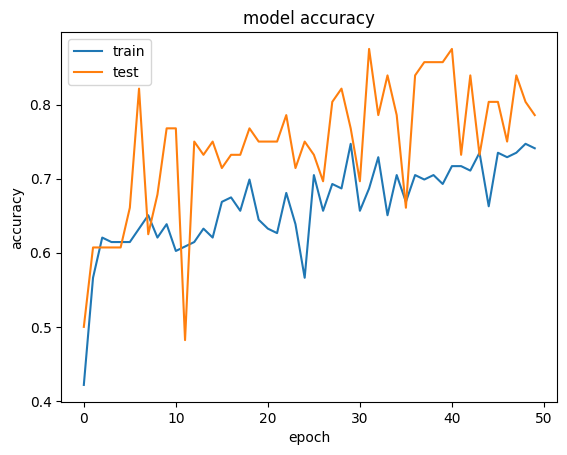

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#視以上執行結果指定較佳的權重
model.load_weights(output_dir+"/weights.09.hdf5")

# 5.總結

# 6.資料來源
### kaggle資料集 : Brain MRI Images for Brain Tumor Detection
### 資料集解釋 : 總共253個檔案，其中no有98個檔案，Yes有155個檔案
### [資料集鏈接][1]
### [參考模型1][2]
### [參考模型2][3]

[1]:<https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection?select=yes> "Brain MRI資料鏈接"
[2]: <https://www.kaggle.com/code/aissaasasd/brain-tumor-detector-92> "參考模型1"
[3]: <https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16> "參考模型2"